# Trabalho 2

* Aluno : Gabriel Borin Macedo
* RA : 197201

## Descrição do trabalho

O objetivo deste trabalho é coletar algumas medidas de objetos presentes em imagens digitais. Essas características serão de centroide, área em _pixels_, encontrar as bordas dos objetos e assim por diante

## Parte 0 : criação de função úteis para o programa

Inicialmente, será definido algumas funções úteis para este _notebook_

In [1]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import os

from glob import glob
from skimage.measure import label, regionprops_table


def read_images(images_path: list[str]) -> tuple[list, list]:
    """
    Função que realiza a leitura de imagens no diretório e retorna uma tupla de lista que contém
    respectivamente as imagens monocromáticas e no padrão RGB

    Args:
        images_path (list[str]): lista de strings que contém o caminho para leitura de todas as imagens

    Notes:
        esse código foi baseado neste (https://docs.opencv.org/3.4/de/d25/imgproc_color_conversions.html#:~:text=The%20conversion%20from%20a%20RGB,done%20with%20cv%3A%3AmixChannels.)

    Returns (tuple[list, list]):
        retorna uma tupla que contém respectivamente as imagens monocromáticas e no padrão RGB

    """

    gray_images_vec = []
    rgb_images_vec = []

    for img_path in images_path:
        print("Lendo a imagem de nome {}".format(img_path))

        # Estamos lendo a imagem em BGR e depois convertendo para RGB
        img_rgb = cv2.imread(img_path)[..., ::-1]

        # Fazendo a conversão de RGB para escala de cinza
        img_gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)

        gray_images_vec.append(img_gray)
        rgb_images_vec.append(img_rgb)

    return gray_images_vec, rgb_images_vec


def plot_figures_in_line(first_img: np.ndarray, second_img: np.ndarray, title1: str = "",
                         title2: str = "", **kwargs: dict) -> None:
    """
    Função que realiza a plotagem de duas imagens na horizontal.

    Args:
        first_img (np.ndarray): um vetor que representa a imagem mais à esquerda
        second_img (np.ndarray): um vetor que representa a imagem mais à direita
        title1 (str): string que representa o título da imagem mais à esquerda
        title2 (str): string que representa o título da imagem mais à direita
        **kwargs (dict): dicionário que contém os parâmetros de salvar a imagem, o tamanho da figura e se o png será salvo como uma figura transparente

    Returns (None):

    """

    if "save_fig" in kwargs.keys():
        save_fig_name = kwargs.pop("save_fig")
        save_dir = kwargs.pop("save_dir")

    else:
        save_fig_name = ""
        save_dir = ""

    if "figsize" in kwargs.keys():
        figsize_val = kwargs.pop("figsize")

    else:
        figsize_val = (15, 15)

    if "fontsize_title" in kwargs.keys():
        fontsize_title = kwargs.pop("fontsize_title")

    else:
        fontsize_title = 20

    if "first_cmap" in kwargs.keys():
        first_cmap = kwargs.pop("first_cmap")

    else:
        first_cmap = None

    if "second_cmap" in kwargs.keys():
        second_cmap = kwargs.pop("second_cmap")

    else:
        second_cmap = None

    fig, ax = plt.subplots(1, 2, figsize=figsize_val)

    # Plot da imagem rgb

    if first_img is not None:
        ax[0].imshow(first_img, cmap=first_cmap, vmin=first_img.min(), vmax=first_img.max())

    else:
        ax[0].imshow(first_img, vmin=first_img.min(), vmax=first_img.max())

    ax[0].set_title(title1, fontsize=fontsize_title)

    # Plot da imagem em tom de cinza
    if second_cmap is not None:
        ax[1].imshow(second_img, cmap=second_cmap, vmin=second_img.min(), vmax=second_img.max())

    else:
        ax[1].imshow(second_img, vmin=second_img.min(), vmax=second_img.max())

    ax[1].set_title(title2, fontsize=fontsize_title)

    for a in ax:
        a.axis("off")
    if save_fig_name:
        os.makedirs(save_dir, exist_ok=True)
        plt.savefig(save_dir + save_fig_name)

    plt.show()


def extract_image_info(image: np.ndarray) -> tuple[pd.DataFrame, np.ndarray]:
    """
    Função que extrai as informações de área, perimetro, ecentricidade e solidez dos objetos de uma imagem e retorna
    uma tupla que contém um pd.Dataframe que contém estas informações e um np.ndarray que representa a imagem de rótulos de cada
    objeto encontrado na imagem

    Args:
        image (np.ndarray): imagem de entrada

    Returns (tuple[pd.DataFrame, np.ndarray]):
        retorna um dataframe que contém as informações de área, perimetro, ecentricidade e solidez dos objetos de uma imagem e um numpy ndarray
        que representa a imagem de labels dos objetos encontrado na imagem

    """

    """
    A máscara é subtraida por 1, pois os valores de labels gerados utilizando esta função
    são de 1 à n. Por causa disso, como queremos considerar que 0 é o nosso fundo, apenas subtraimos pelo valor 1
    e das maneira, consideramos o background como 0 ao invés de 1
    """
    label_img = label(image) - 1
    print("total de objetos detectados : {}".format(label_img.max()))
    props = regionprops_table(label_img, properties=("area",
                                                     "perimeter",
                                                     "eccentricity",
                                                     "solidity",
                                                     "centroid",
                                                     "moments"))
    df = pd.DataFrame(props)
    return df, label_img

## Parte 1 : Conversão de imagens no tom de cinza para a escala monocromática

Para esta parte do programa, será criado uma função que realiza a leitura de uma imagem RGB e converte para a escala monocromática. Desta forma, será utilizada a função [cv2.cvtColor](https://docs.opencv.org/3.4/de/d25/imgproc_color_conversions.html).

De forma geral, esta funçao cria uma *transformada linear* $T: R^{n\text{ x }m\text{ x }3} \rightarrow R^{n\text{ x }m$ definida da seguinte forma : dado uma imagem $A \in R^{n\text{ x }m\text{ x }3}$ e $Y \in R^{n\text{ x }m}$ com $T(A) = Y$. Temos que

$$
T(A) = 0.299*R + 0.587*G + 0.114*B = Y
$$

onde *R* é a banda de cor vermelha, *G* é a banda de cor verde e *B* é a banda de cor azul da imagem $A$

### Leitura do caminho das imagens

Inicialmente, será definido o caminho para a leitura das imagens utilizando a biblioteca _glob_

In [2]:
"""
É realizado um sort no vetor dos arquivos para leitura pois a função glob
não necessariamente realiza uma leitura dos arquivos em ordem alfabética
então, é utilziado o sorted para deixar em ordem alfabética os arquivos para leitura
"""
image_files_path = sorted(glob("Imagens/*"))

gray_images, rgb_images = read_images(image_files_path)

Lendo a imagem de nome Imagens/objetos1.png
Lendo a imagem de nome Imagens/objetos2.png
Lendo a imagem de nome Imagens/objetos3.png


libpng warning: iCCP: profile 'default_rgb.icc': 0h: PCS illuminant is not D50
libpng warning: iCCP: profile 'default_rgb.icc': 0h: PCS illuminant is not D50


### Função para leitura e plotagem das imagens

Agora,será feito uma célula que pega as imagens rgb e em escala de cinza e realiza o _plot_ das imagens

Nome da imagem de entrada : objetos1
Dimensão da imagem monocromática : (327, 563)
Dimensão da imagem rgb : (327, 563, 3)


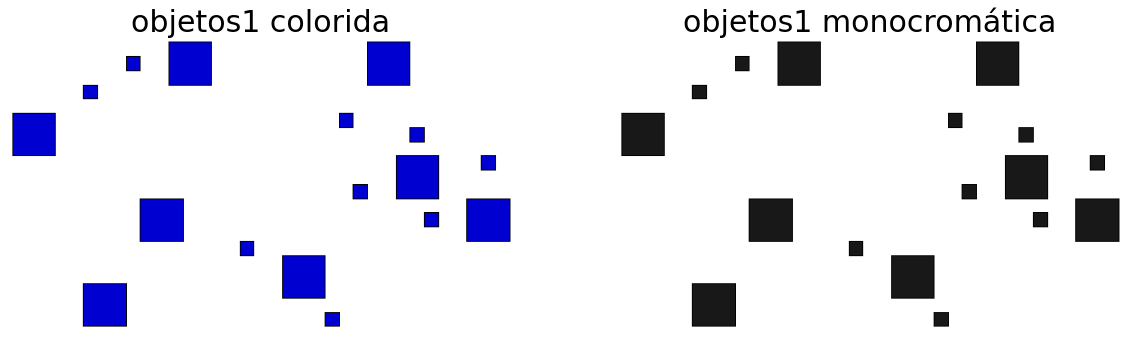

Nome da imagem de entrada : objetos2
Dimensão da imagem monocromática : (343, 563)
Dimensão da imagem rgb : (343, 563, 3)


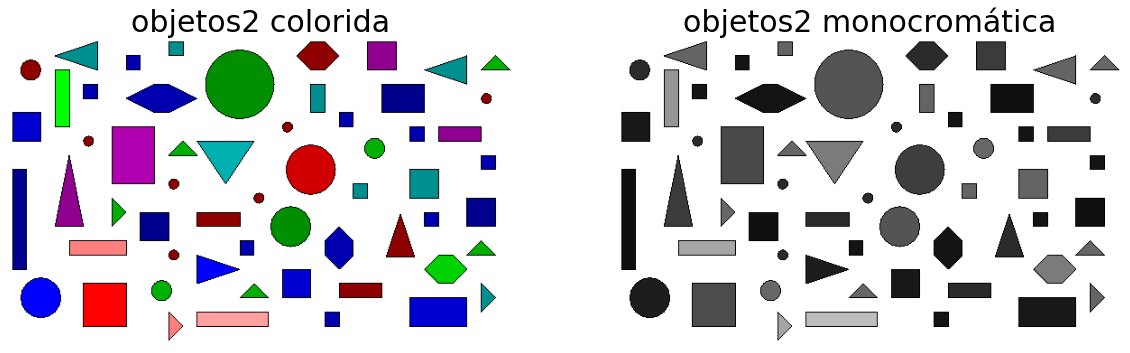

Nome da imagem de entrada : objetos3
Dimensão da imagem monocromática : (238, 238)
Dimensão da imagem rgb : (238, 238, 3)


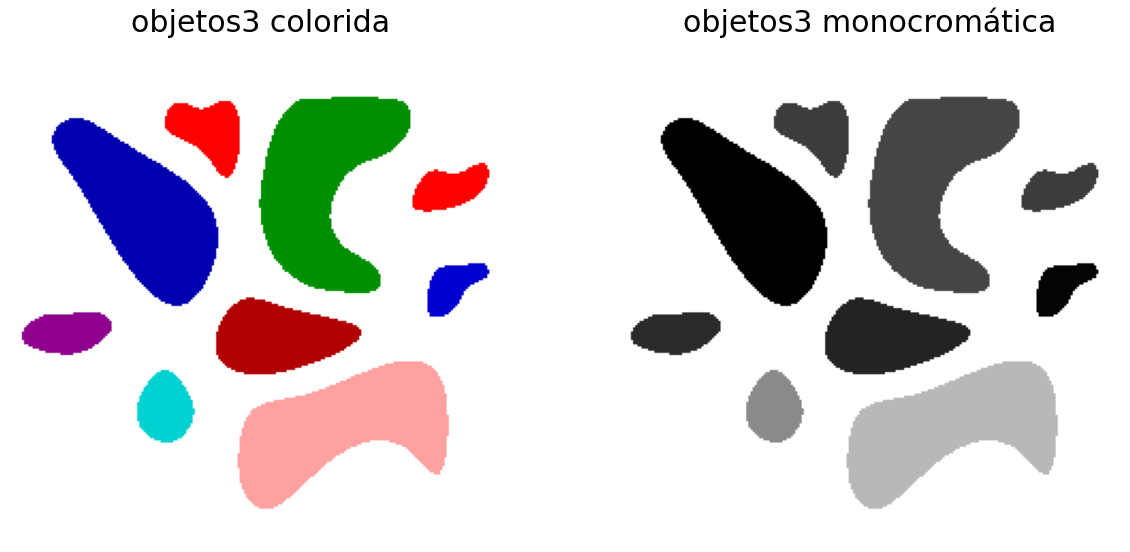

In [3]:
for gray_img, rgb_img, image_name in zip(gray_images, rgb_images, image_files_path):
    # Manipulação da string para se obter o nome do arquivo de imagem
    img_name = image_name.split("/")[-1].split(".")[0]

    print("Nome da imagem de entrada : {}".format(img_name))
    print("Dimensão da imagem monocromática : {}".format(gray_img.shape))
    print("Dimensão da imagem rgb : {}".format(rgb_img.shape))

    plot_figures_in_line(rgb_img, gray_img, title1="{} colorida".format(img_name),
                         title2="{} monocromática".format(img_name),
                         save_dir="ResultadoImagens/ConversaoCores/",
                         save_fig="{}Convertida.png".format(img_name),
                         second_cmap="gray",
                         figsize=(20, 20),
                         fontsize_title=30)

## Parte 2 : Extração do contorno dos objetos

Para esta parte, será feito a extração do contorno dos objetos a partir de imagens digitais. Como exemplo de uso desta função, será utilizado as 3 imagens de objetos fornecidas para este relatório

### Definição da função
Abaixo, é possível visualisar a função que realiza a extração destas informações. Esse código foi baseado utilizando este [_link_](https://learnopencv.com/contour-detection-using-opencv-python-c/) como fonte.

Para deteção das bordas, foi utilizado a função [**cv2.threshold**](https://docs.opencv.org/4.x/d7/d4d/tutorial_py_thresholding.html) que utiliza o método [**cv2.THRESH_BINARY_INV**](https://docs.opencv.org/3.4/d7/d1b/group__imgproc__misc.html#ggaa9e58d2860d4afa658ef70a9b1115576a19120b1a11d8067576cc24f4d2f03754).

In [4]:
def get_image_contour(gray_img: np.ndarray, rgb_image: np.ndarray, file_name: str, t_min: int = 30, t_max: int = 200,
                      plot_image: bool = True, **kwargs: dict) -> tuple[np.ndarray, np.ndarray]:
    """
    Função que extrai os cortonos de uma imagem e retorna uma imagem que contém os cortornos dos objetos da imagem

    Args:
        gray_img (np.ndarray): imagem monocromática
        rgb_image (np.ndarray): imagem na escala RGB
        file_name (str): string que representa o nome do arquivo das imagens
        t_min (int): valor opcional para de threshold mínimo para se utilizar no algorítmo dc v2.threshold. O seu valor padrão é 30
        t_max (int): valor opcional para de threshold máximo para se utilizar no algorítmo do cv2.threshold. O seu valor padrão é 200
        plot_image (bool): boleano que representa
        **kwargs (dict): dicionário que contém alguns parâmetros opcionais tais como a cor para demonstração dos contouros, tamanho da figura e o tamanho da fonte

    Returns:
        (tuple[np.ndarray, np.ndarray]): Retorna uma tupla que contém respectivamente a imagem com os contouros dos objetos detectados e a imagem RGB original com o contouro dos objetos em enfaze

    """

    if "color_mask" in kwargs.keys():
        color_mask = kwargs.pop("color_mask")

    else:
        np.random.seed(31)
        color_mask = (np.random.randint(0, 255), np.random.randint(0, 255), np.random.randint(0, 255))

    if "figsize" in kwargs.keys():
        figsize_val = kwargs.pop("figsize")

    else:
        figsize_val = (20, 20)

    if "fontsize_title" in kwargs.keys():
        fontsize_title = kwargs.pop("fontsize_title")

    else:
        fontsize_title = 20

    # Manipulação da string para se obter o nome do arquivo de imagem
    img_name = file_name.split("/")[-1].split(".")[0]

    print("Nome da imagem de entrada : {}".format(img_name))
    print("Dimensão da imagem monocromática : {}".format(gray_img.shape))

    _, threshold_values = cv2.threshold(gray_img, t_min, t_max,
                                        cv2.THRESH_BINARY_INV)

    contours, _ = cv2.findContours(threshold_values, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

    # Agora, iremos desenhar o contouro tanto para a imagem original

    # Esta função cria uma imagem somente com os contornos
    img_with_contours = cv2.drawContours(np.ones_like(rgb_image) * 255, contours, -1, color_mask, 2).astype(np.uint8)

    # Esta função pega a imagem RGB original e coloca a máscara como os contornos dos objetos encontrados na imagem
    img_with_mask = cv2.drawContours(rgb_image.astype(np.float32), contours, -1, color_mask, 2).astype(np.uint8)

    if plot_image:
        plot_figures_in_line(img_with_contours, img_with_mask, title1="contouro da imagem {}".format(img_name),
                             title2="contorno da imagem {} aplicado na imagem original".format(img_name),
                             save_dir="ResultadoImagens/Contorno/",
                             save_fig="{}contorno.png".format(img_name),
                             figsize=figsize_val,
                             fontsize_title=fontsize_title)

    return contours, img_with_contours

Por fim, iremos utilziar as 3 imagens disponívels de exemplo para testarmos a implementaçao da função. Além disso, iremos salvar as imagens de contouros para aproveitamento de código para a próxima parte do trabalho

Nome da imagem de entrada : objetos1
Dimensão da imagem monocromática : (327, 563)


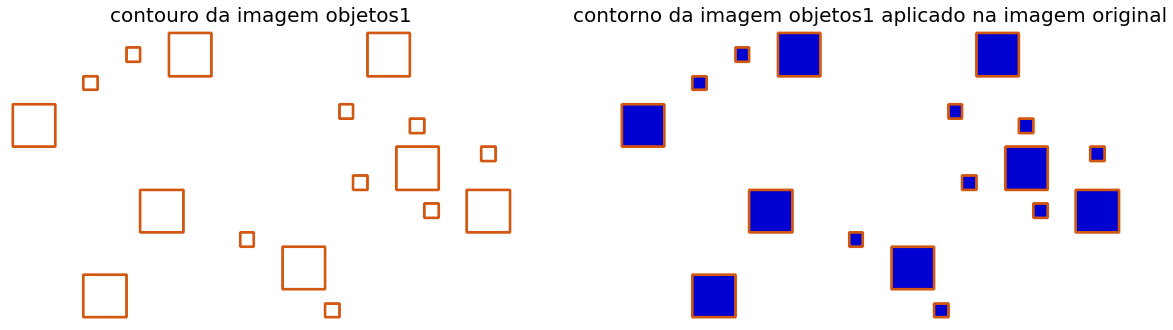

Nome da imagem de entrada : objetos2
Dimensão da imagem monocromática : (343, 563)


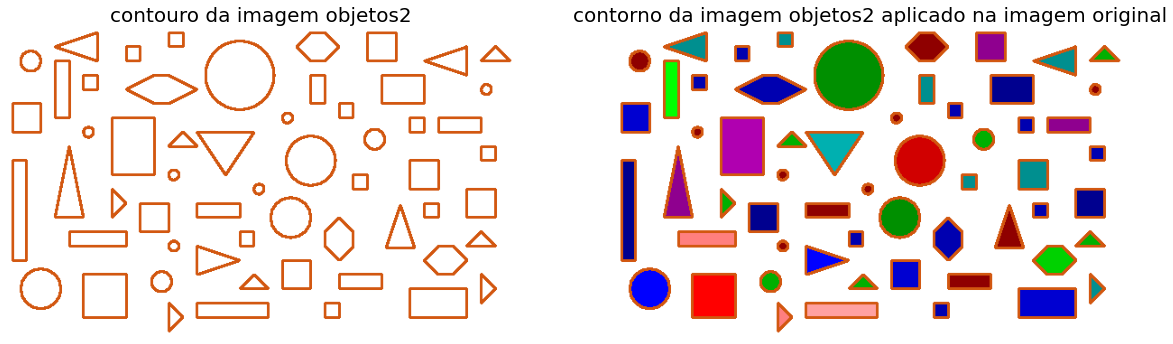

Nome da imagem de entrada : objetos3
Dimensão da imagem monocromática : (238, 238)


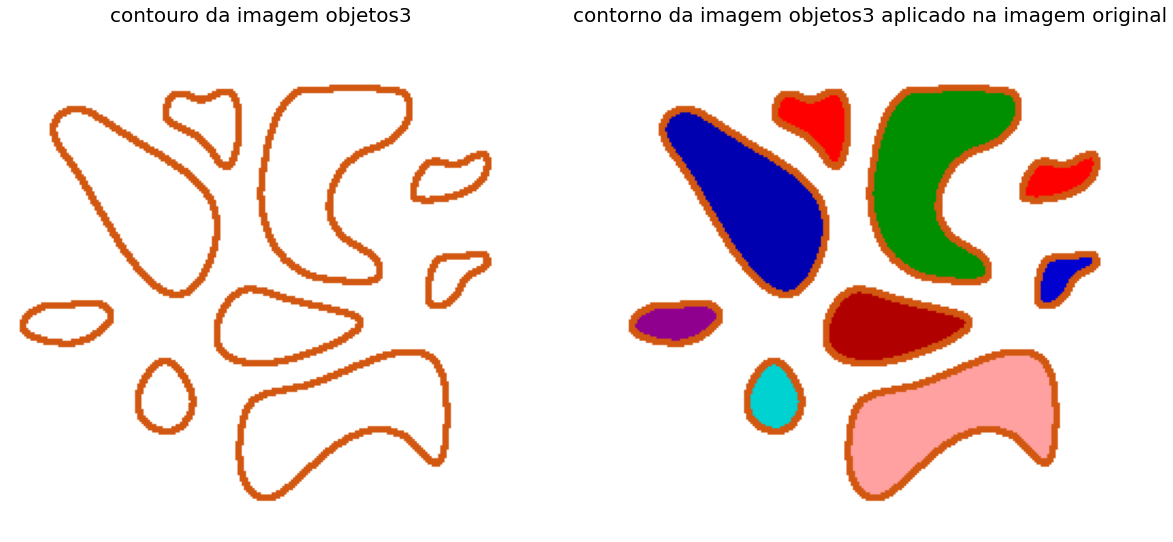

In [5]:
# Lista que salvará todas as imagens com as bordas dos objetos encontrados
images_contours = []

for gray_img, rgb_image, image_name in zip(gray_images, rgb_images, image_files_path):
    img_contour, _ = get_image_contour(gray_img, rgb_image, image_name, t_min=190, t_max=255)
    images_contours.append(img_contour)

## Parte 3 : Extração de propriedades dos objetos.
Para esta parte, será definido uma função que realiza que a extração de informação dos objetos e que cria uma rotulação para cada objeto encontrado. Isso será feito criando um número que será posto no centroide de cada região encontrada.

Para a função de centroide utilizada, será feito utilizando a função [_region_props_](https://scikit-image.org/docs/stable/api/skimage.measure.html#skimage.measure.regionprops)

### Criação da função
Abaixo, é possível visualizar a função utilizada para extração das propriedades de cada objeto e rotulação de cada região encontrada

In [6]:
def place_text_to_objects(gray_img: np.ndarray, file_name: str, rgb_img: np.ndarray,
                          color: tuple[int, int, int] = (0, 0, 0), thickness: int = 1,
                          fig_size: tuple[int, int] = (10, 10), move_centroid: tuple[float, float] = (0.0, 0.0),
                          **kwargs: dict) -> tuple[np.ndarray, list[int]]:
    """

    Função que identifica todos os objetos de uma imagem, identificando algumas propriedades destas regiões tais como área, perímetro, excentricidade, solidez
    e as coordenadas aproximadas dos centroides de cada objeto. Por fim, é feito uma plotagem de todas as regiões encontradas e rotuladas.

    Notes:
         O número da região em cada rótulo são postos utilizando o centroide de cada objeto e usando a biblioteca do skimage

    Args:
        gray_img (np.ndarray): imagem monocromática
        file_name (str): nome do arquivo da imagem
        rgb_img (np.ndarray): imagem na escala RGB
        color (tuple[int, int, int]): tupla de 3 coordenadas utilizada para representar a cor do texto na região de label. O valor padrão é de (0, 0, 0)
        thickness (int): valor inteiro que representa a "grossura" do texto na rotulação. O valor padrão é 1
        fig_size (tuple[int, int]): valor utitlizado para definir o tamanho do plot da imagem. O valor padrão é de (10, 10)
        move_centroid (tuple[float, float]): valor utilizado para mover o número de rotulação de cada objeto. O valor padrão é de (0.0, 0.0)
        **kwargs (dict): dicionário que contém argumentos de imagem com apenas as bordas dos objetos e os valores de threshold mínimo e máximo para serem utilizados

    Returns (tuple[np.ndarray, list[int]]):
        retorna uma tupla que contém respectivamente a imagem com os objetos rotulados e uma lista de inteiros que contém todos os valores de área dos objetos na imagem

    """

    np.random.seed(31)

    if "img_contour" in kwargs.keys():
        img_contour = kwargs.pop("img_contour")

    else:
        if "t_min" in kwargs.keys():
            t_min = kwargs.pop("t_min")

        else:
            t_min = 190

        if "t_max" in kwargs.pop("t_max"):
            t_max = kwargs.pop("t_max")

        else:
            t_max = 255

        img_contour = get_image_contour(gray_img, rgb_image, image_name, t_min=t_min, t_max=t_max)

    # Manipulação da string para se obter o nome do arquivo de imagem
    img_name = file_name.split("/")[-1].split(".")[0]

    text_to_print = 50 * "=" + " {} ".format(img_name) + 50 * "="

    # extraindo as informações dos objetos pertencentes na imagem
    df_info_objs, _ = extract_image_info(gray_img)

    # Inicializando algumas variáveis

    # Lista que conterá todos os valores de áreas dos objetos
    area_list_val = []

    # Índice para percorrer a matriz de label que contém todos os objetos
    object_index = 0

    # Inicializando a imagem com 255 para preencher esta imagem com a máscara de rótulos de cada região
    img_with_text = np.ones_like(rgb_img) * 255

    # percorrendo o total de objetos da imagem e preenchendo a imagem de borda com a cor de label desejada
    for _ in img_contour:
        img_with_text = cv2.drawContours(img_with_text, img_contour, object_index,
                                         (np.random.randint(190, 254), np.random.randint(190, 254),
                                          np.random.randint(190, 254)), -1)
        object_index += 1

    # para esta parte, é extraido todas as característias dos objetos pertencentes da imagem
    print(text_to_print)
    print("Número de regiões : {}\n".format(len(df_info_objs)))
    for i in range(0, len(df_info_objs)):
        area_list_val.append(df_info_objs["area"][i])
        centroid_coord = (
            int(df_info_objs["centroid-1"][i] + move_centroid[0]),
            int(df_info_objs["centroid-0"][i] + move_centroid[1]))

        print("região {}: área {}: perímetro: {} excentricidade: {} solidez: {} ".format(i, df_info_objs["area"][i],
                                                                                         df_info_objs["perimeter"][
                                                                                             i], df_info_objs[
                                                                                             "eccentricity"][i],
                                                                                         df_info_objs["solidity"][
                                                                                             i]))
        print("coordenadas do centroid : (x = {}, y = {})\n".format(centroid_coord[0], centroid_coord[1]))

        # font
        font = cv2.FONT_HERSHEY_SIMPLEX

        font_scale = 0.5

        img_with_text = cv2.putText(img_with_text, "{}".format(i), centroid_coord, font,
                                    font_scale, color, thickness, cv2.LINE_AA)

    print(len(text_to_print) * "=" + "\n")
    plot_figures_in_line(rgb_img, img_with_text, title1="imagem {}".format(img_name),
                         title2="{} rotulada".format(img_name),
                         save_dir="ResultadoImagens/Propriedades/",
                         save_fig="{}Label.png".format(img_name),
                         first_cmap="gray",
                         second_cmap="gray",
                         figsize=fig_size,
                         fontsize_title=25)

    return img_with_text, area_list_val

Com isto, será novamente utilizado as iamgens de exemplo como exemplo de funcionamento desta função.

Além disso, iremos salvar os valores de área encontrado em uma lista para reaproveitamento de código para a parte final do relatório

total de objetos detectados : 17
================================================== objetos1 ==================================================
Número de regiões : 17

região 0: área 2162: perímetro: 182.0 excentricidade: 0.20523051726629585 solidez: 1.0 
coordenadas do centroid : (x = 192, y = 39)

região 1: área 2162: perímetro: 182.0 excentricidade: 0.20523051726629585 solidez: 1.0 
coordenadas do centroid : (x = 412, y = 39)

região 2: área 210: perímetro: 54.0 excentricidade: 0.35981145856446234 solidez: 1.0 
coordenadas do centroid : (x = 129, y = 39)

região 3: área 210: perímetro: 54.0 excentricidade: 0.35981145856446234 solidez: 1.0 
coordenadas do centroid : (x = 82, y = 70)

região 4: área 2116: perímetro: 180.0 excentricidade: 0.0 solidez: 1.0 
coordenadas do centroid : (x = 19, y = 117)

região 5: área 210: perímetro: 54.0 excentricidade: 0.35981145856446234 solidez: 1.0 
coordenadas do centroid : (x = 365, y = 102)

região 6: área 225: perímetro: 56.0 excentricidade: 0.0 

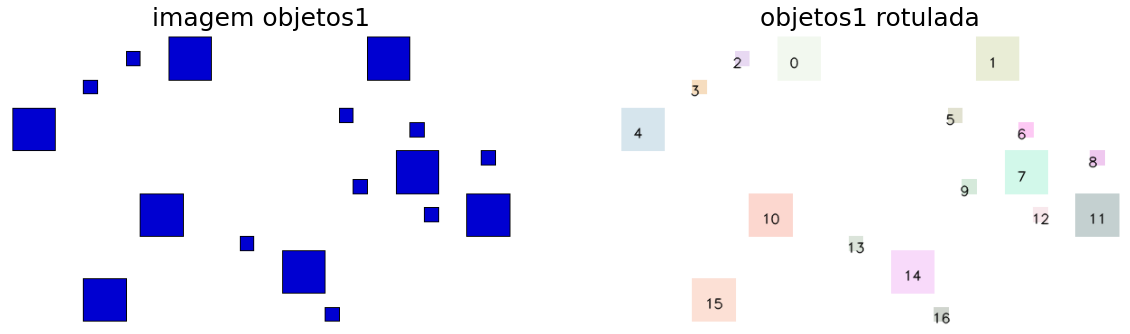

total de objetos detectados : 58
================================================== objetos2 ==================================================
Número de regiões : 58

região 0: área 690: perímetro: 127.18376618407356 excentricidade: 0.8155647091831716 solidez: 0.9610027855153204 
coordenadas do centroid : (x = 74, y = 31)

região 1: área 210: perímetro: 54.0 excentricidade: 0.35981145856446234 solidez: 1.0 
coordenadas do centroid : (x = 177, y = 23)

região 2: área 930: perímetro: 113.19595949289334 excentricidade: 0.6509959843025376 solidez: 1.0 
coordenadas do centroid : (x = 334, y = 31)

região 3: área 930: perímetro: 118.0 excentricidade: 0.2520747243709028 solidez: 1.0 
coordenadas do centroid : (x = 405, y = 31)

região 4: área 4402: perímetro: 245.6223663640862 excentricidade: 0.06766830098591488 solidez: 0.9865531151949798 
coordenadas do centroid : (x = 247, y = 62)

região 5: área 210: perímetro: 54.0 excentricidade: 0.35981145856446234 solidez: 1.0 
coordenadas do centroi

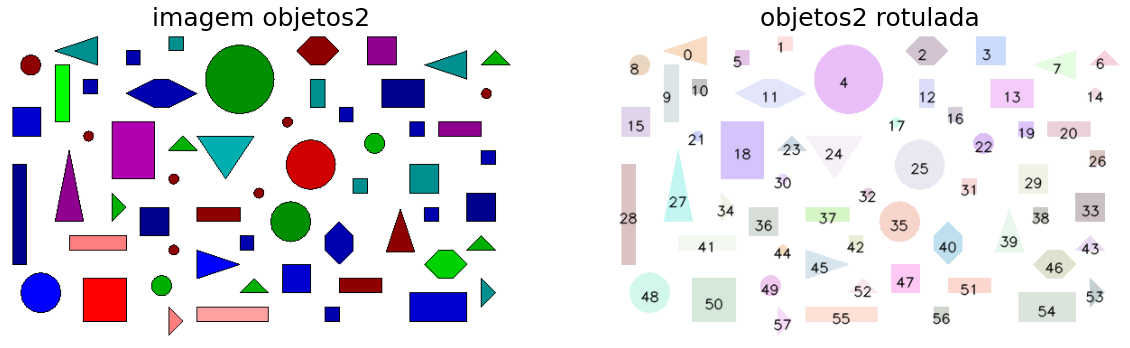

total de objetos detectados : 9
================================================== objetos3 ==================================================
Número de regiões : 9

região 0: área 3969: perímetro: 313.7645019878171 excentricidade: 0.8163620640925742 solidez: 0.7466139954853274 
coordenadas do centroid : (x = 137, y = 78)

região 1: área 791: perímetro: 119.9827560572969 excentricidade: 0.7411034746078128 solidez: 0.8958097395243488 
coordenadas do centroid : (x = 84, y = 53)

região 2: área 3584: perímetro: 259.4629867976521 excentricidade: 0.8980731711879257 solidez: 0.9755035383777899 
coordenadas do centroid : (x = 53, y = 90)

região 3: área 540: perímetro: 99.25483399593904 excentricidade: 0.8895857569166923 solidez: 0.9015025041736227 
coordenadas do centroid : (x = 196, y = 80)

região 4: área 438: perímetro: 88.76955262170047 excentricidade: 0.8559229397121942 solidez: 0.9087136929460581 
coordenadas do centroid : (x = 198, y = 126)

região 5: área 1684: perímetro: 174.1248916

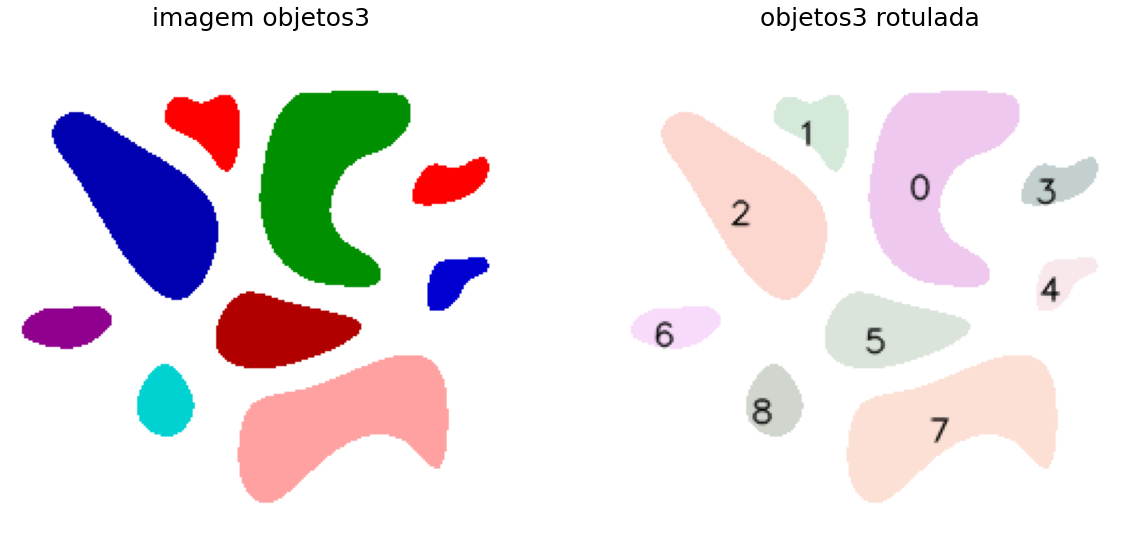

In [7]:
# Estas tuplas estão sendo utilizadas como coordenadas de translação da numeração de cada região
move_values = ((-10.0, 10.0), (-10.0, 10.0), (-10.0, 10.0))

# lista que contém todos os valores de área para imagem
area_values_vec = []
for gray_img, rgb_img, img_contour, image_name, move_value in zip(gray_images, rgb_images, images_contours,
                                                                  image_files_path, move_values):
    _, object_area = place_text_to_objects(gray_img, image_name, img_contour=img_contour, move_centroid=move_value,
                                           rgb_img=rgb_img, color=(1, 1, 1),
                                           fig_size=(20, 20))
    area_values_vec.append(object_area)

## Parte 4 : Histograma de Área dos Objetos
Por fim, será feito a _plotagem_ dos valores de área dos objetos encontrados seguindo a regra : Data a o valor de uma área de um objeto sendo $V_{area}$, iremos classificar a região como

* **pequena** se $V_{area} < 1500$
* **média** se $1500 \leq V_{area} < 3000$
* **grande** se $V_{area} \geq 3000$

### Definição da função

Para esta parte, será definido a função que realiza a plotagem do histograma da área em regiões consideradas pequenas, médias e grandes. Está função utilizou esta [referência](https://datatofish.com/bar-chart-python-matplotlib/).

In [8]:
def get_hist_areas(areas_values: list[int], file_name: str,
                   hist_interval: tuple[int, int] = (1500, 3000)) -> pd.DataFrame:
    """
    Função que cria o histograma a partir dos valores de área de cada imagem e realiza a separação destes valores em regiões pequenas, médias e grandess
    Por fim, esta função retorna um dataframe que contém uma chave de área e a quantidade objetos de cada

    Args:
        areas_values (list[int]): lista que contém os valores de área de cada objeto extraido na imagem
        file_name (str): string que representa o nome da imagem
        hist_interval (tuple[int, int]): tupla de dois valores inteiros que contém o valor mínimo e máximo de área para ser utilizado para separação das regoĩes pequenas, médias e grandes

    Returns (pd.DataFrame):
        retorna um pandas dataframe que contém a informação da áreas e suas respectivaes contagem


    """

    # Manipulação da string para se obter o nome do arquivo de imagem
    img_name = file_name.split("/")[-1].split(".")[0]

    text_to_print = 50 * "=" + " {} ".format(img_name) + 50 * "="
    print(text_to_print)

    # Inicializando o dataframe que contém a classificação de cada área e a contagem de cada tipo de área
    all_object_areas = {"area": ["pequena", "media", "grande"],
                        "n_objects": [0, 0, 0]
                        }

    for area_value in areas_values:
        if (area_value < hist_interval[0]):
            all_object_areas["n_objects"][0] += 1
        elif (area_value >= hist_interval[0] and area_value < hist_interval[1]):
            all_object_areas["n_objects"][1] += 1
        else:
            all_object_areas["n_objects"][2] += 1

    df = pd.DataFrame(all_object_areas)

    print("Número de regiões pequenas : {}".format(all_object_areas["n_objects"][0]))
    print("Número de regiões médias : {}".format(all_object_areas["n_objects"][1]))
    print("Número de regiões grandes : {}".format(all_object_areas["n_objects"][2]))

    print(len(text_to_print) * "=" + "\n")

    colors = ["green", "blue", "purple"]
    plt.subplots(figsize=(10, 10))
    plt.bar(df["area"], df["n_objects"], color=colors)
    plt.title("histograma de área dos objetos de {}".format(img_name), fontsize=20)
    plt.xlabel("Valor da área", fontsize=20)
    plt.ylabel("número de objetos", fontsize=20)
    plt.grid(True)
    plt.savefig("ResultadoImagens/Histogramas/{}.png".format(img_name))
    plt.show()

    return df

Agora, será iterado cada volume de cada objeto e será criado o histograma de cada valor

================================================== objetos1 ==================================================
Número de regiões pequenas : 9
Número de regiões médias : 8
Número de regiões grandes : 0



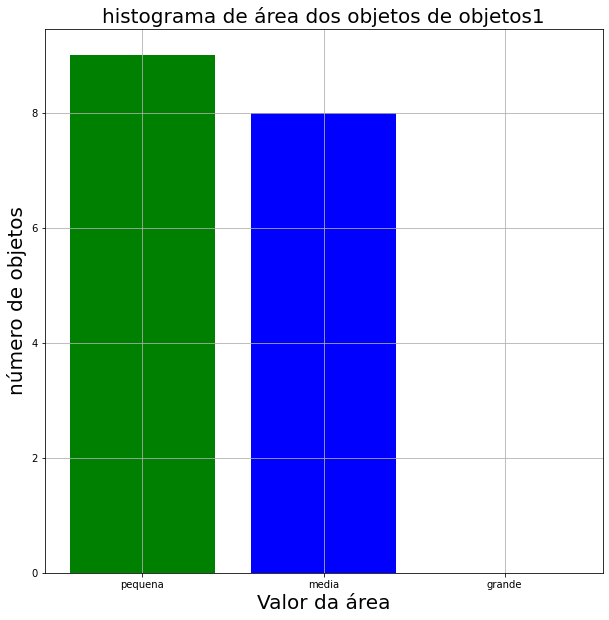

================================================== objetos2 ==================================================
Número de regiões pequenas : 52
Número de regiões médias : 5
Número de regiões grandes : 1



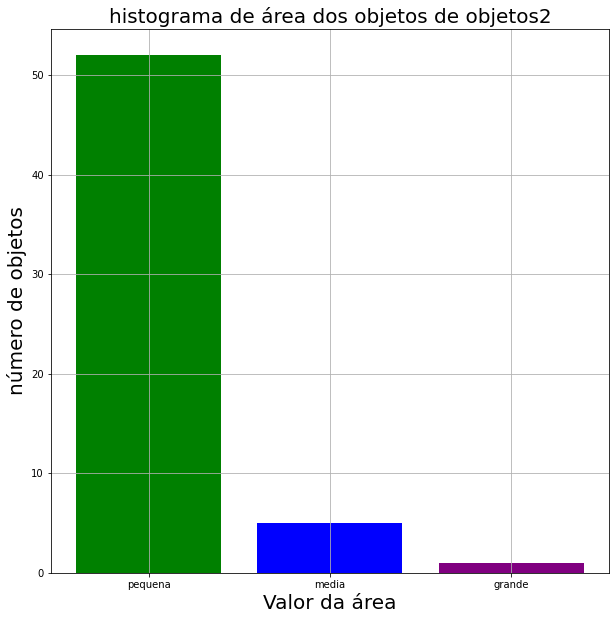

================================================== objetos3 ==================================================
Número de regiões pequenas : 5
Número de regiões médias : 1
Número de regiões grandes : 3



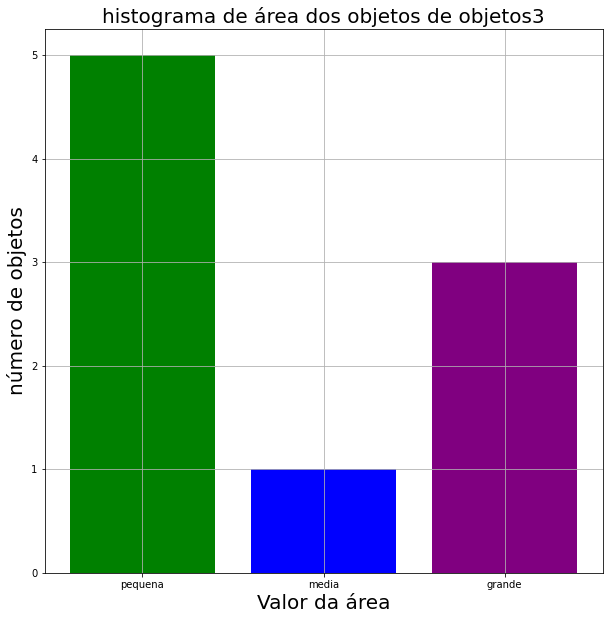

In [9]:
for area_values, img_path in zip(area_values_vec, image_files_path):
    _ = get_hist_areas(area_values, img_path)